# SmartChurn: Targeted Discounts for Customer Retention  

### Project Overview

Customer churn remains one of the most pressing challenges for energy companies, as it directly impacts both revenue stability and long-term profitability.  

The **SmartChurn project** applies machine learning to predict customer churn, identify the key drivers of attrition, and evaluate the business impact of retention strategies.  

Our findings suggest that broad, across-the-board discounts are not profitable. However, when discounts are applied selectively to customers most at risk of churning, they become an effective strategy — improving retention rates while still generating a net positive profit for the business.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

### Load data

In [2]:
df = pd.read_csv('data_for_predictions.csv')

In [3]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [4]:
# Quick look at the data
print(df.shape)

(14606, 63)


In [5]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


### Data Preparation

Following exploratory data analysis and feature engineering, the dataset is prepared for modeling. We separate the target variable (**churn**) from the predictive features, while retaining the customer ID solely for reference and tracking purposes.

#### Target

In [6]:
y = df['churn'].values

#### Features

In [7]:
X = df.drop(columns=['churn', 'id'])

In [8]:
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Features shape: (14606, 61), Target shape: (14606,)


The final dataset includes **61 predictive features** and covers more than **14,000 customers**. This balanced set of engineered variables and sufficient sample size provides a strong foundation for building a reliable churn prediction model.

### Model Random Forest

For this project, we train a **Random Forest Classifier**.  
Rather than relying on a single decision tree, Random Forest builds an *ensemble* of many trees and then combines their outputs. The intuition is simple: while one tree may overfit or underfit, a large collection of trees — each trained on slightly different data — can collectively provide a more stable and accurate prediction.

In this notebook, we set the number of trees (`n_estimators`) to **1000**. Using more trees helps the model generalize better by averaging across many “weak learners,” though it also increases training time.

**Why Random Forest?**
- It does not require feature scaling, making it flexible across different types of features.  
- It can capture complex, non-linear relationships in the data.  
- By aggregating many trees, it reduces the risk of overfitting that a single decision tree often faces.  

**Things to keep in mind:**
- Training can be computationally expensive with a large number of trees and big datasets.  
- Unlike a single tree, the model is harder to interpret because predictions come from hundreds of trees working together.  

For a deeper dive into the available parameters and fine-tuning options, the official documentation provides an excellent resource: 
[`scikit-learn:` Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

# Initialization
pred_train_labels = np.zeros(shape=(X.shape[0], 2))
feature_importance_df = pd.DataFrame({'feature_name': X.columns,'feature_importance': [0]*len(X.columns)})

# Stratified K-Fold CV
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
fold_counter = 1

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Build model
    rf = RandomForestClassifier(n_estimators=1000, random_state=56)
    # Train model
    rf.fit(X_train, y_train)
    # Predict
    pred_train_labels[test_index] = rf.predict_proba(X_test)
   # Accumulate feature importance
    feature_importance_df['feature_importance'] += rf.feature_importances_

    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} "
          f"Recall {recall_score(y_test, rf.predict(X_test)):.3f} "
          f"Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter += 1

# Overall metrics
pred_y = pred_train_labels.argmax(axis=1)
print("\nOverall Metrics")
print(f"Total  Precision {precision_score(y, pred_y):.3f} "
      f"Recall {recall_score(y, pred_y):.3f} "
      f"Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.789 Recall 0.053 Accuracy 0.907
Fold 2 Precision 0.786 Recall 0.077 Accuracy 0.908
Fold 3 Precision 0.880 Recall 0.077 Accuracy 0.909
Fold 4 Precision 0.789 Recall 0.053 Accuracy 0.907
Fold 5 Precision 0.783 Recall 0.064 Accuracy 0.908

Overall Metrics
Total  Precision 0.807 Recall 0.065 Accuracy 0.908


#### Evaluation Metrics

To evaluate the model’s performance, we look beyond accuracy alone.  
While accuracy gives us the ratio of correct predictions to the total observations, it can often be misleading in imbalanced datasets such as churn prediction.

That’s why we also include two additional metrics:  

- **Precision**: How often the model correctly predicts churn when it says a customer will churn. This helps us avoid flagging loyal customers as churners.  
- **Recall**: How well the model is able to identify actual churners. This is crucial, because missing a churner means losing the chance to take preventive action.  

Alongside these metrics, we generate a **classification report** and a **confusion matrix** to give a more detailed view of model performance across both churners and non-churners.

In [10]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y, pred_y))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     13187
           1       0.81      0.06      0.12      1419

    accuracy                           0.91     14606
   macro avg       0.86      0.53      0.54     14606
weighted avg       0.90      0.91      0.87     14606



#### Confusion Matrix  

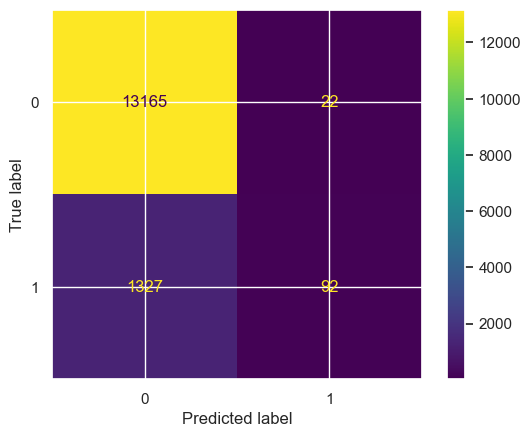

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, pred_y, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

Looking at the evaluation metrics, the model initially seems to perform well, with an overall accuracy of **91%**. However, accuracy alone can be misleading in the context of an imbalanced dataset such as churn prediction.

From the confusion matrix, we can see that the model correctly identifies almost all of the **non-churners (class 0)** — achieving over 13,165 true negatives with only 22 false positives. This explains why the accuracy is high: the majority class dominates the dataset, and the model is very good at recognizing it.

The real challenge lies in identifying the **churners (class 1)**. Out of more than 1,327 actual churn cases, the model correctly classifies only 92. This corresponds to a recall of just **0.06**, meaning the model misses the vast majority of customers who are at risk of leaving. In other words, we are predicting too many false negatives.

Precision for churners, however, is relatively strong at **0.81**. This indicates that when the model does predict churn, it is usually correct — but the problem is that it rarely makes such predictions. This imbalance between precision and recall highlights the main limitation we need to address.

In summary, the current Random Forest model is excellent at predicting customers who stay, but performs poorly at detecting those who leave. For churn analysis, this is critical because failing to identify churners means losing the opportunity to take preventive action.

#### Feature Importance

To gain more insight into the model’s behavior, we can now look at the **feature importances** aggregated across all folds. This helps us understand which features contribute most to the model’s predictions and potentially guide new ideas for feature engineering.

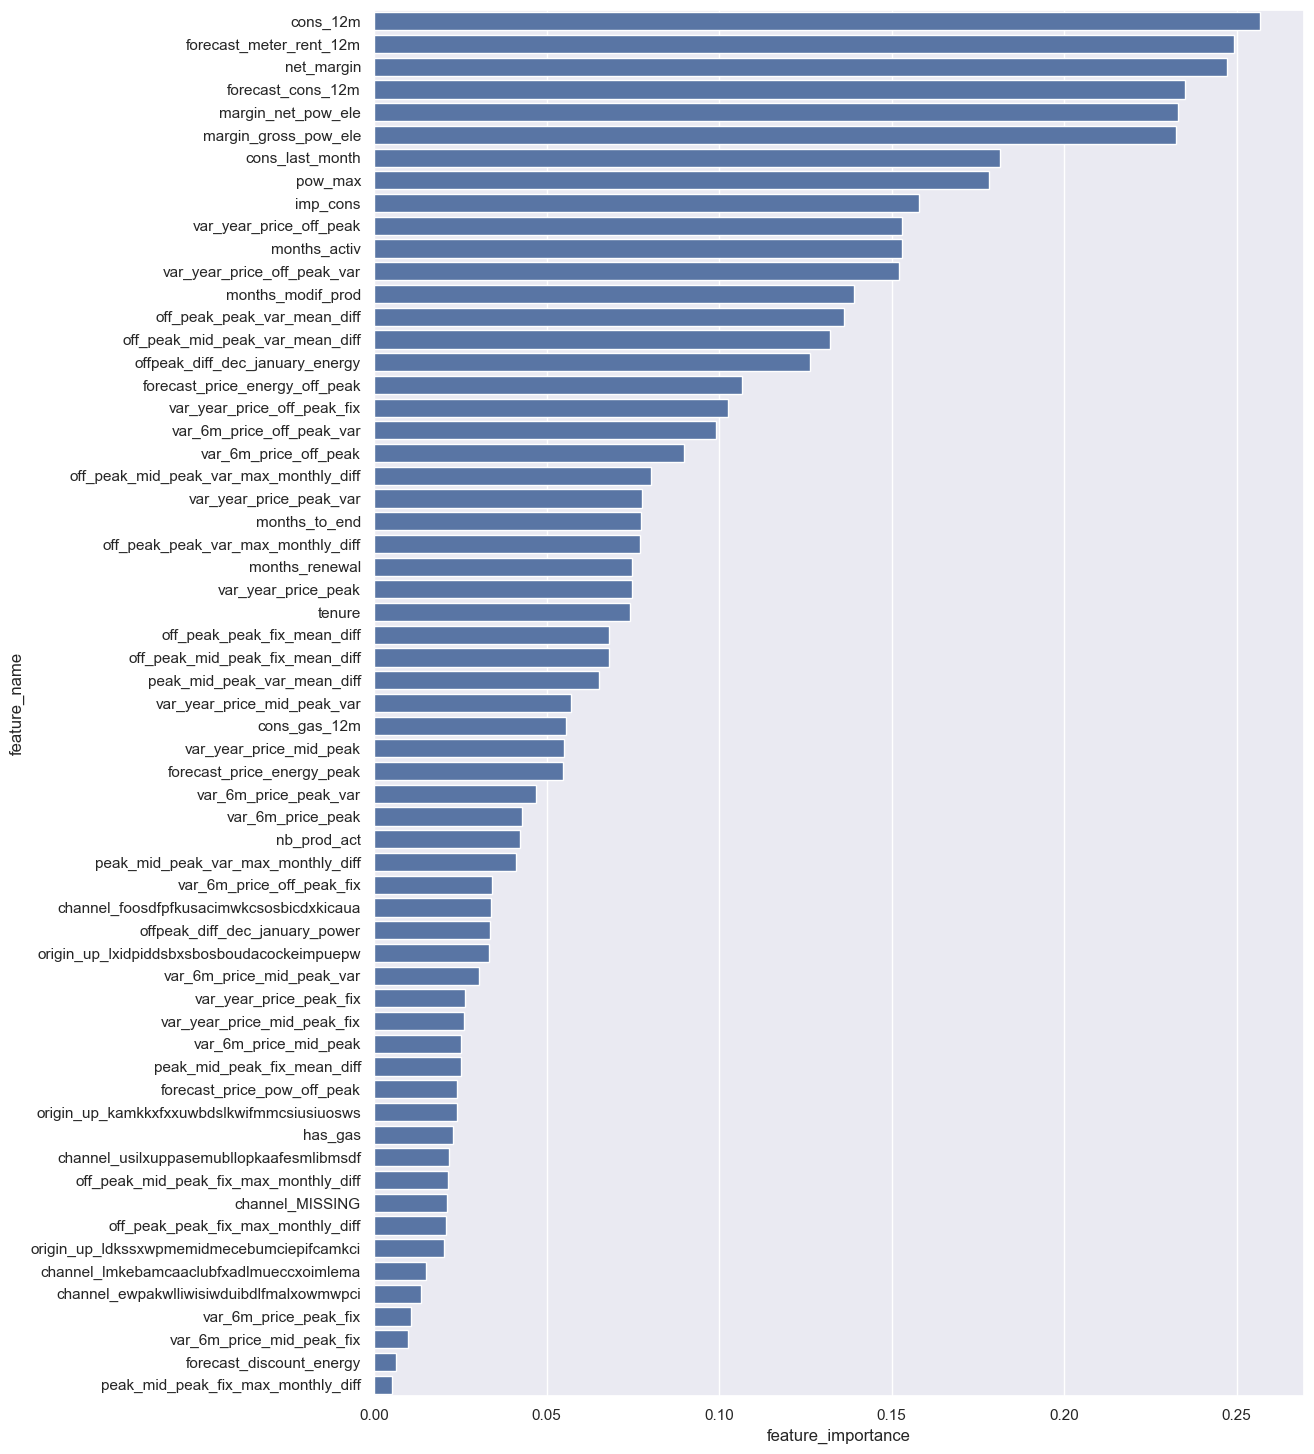

In [12]:
plt.figure(figsize=(12,18))
sns.barplot(data=feature_importance_df.sort_values(by='feature_importance', ascending=False),
            y='feature_name', x='feature_importance')
plt.show()

From the analysis, we can see that **forecasted meter rent over the next 12 months** (`forecast_meter_rent_12m`) and **annual energy consumption** (`cons_12m`) emerge as the strongest drivers of churn. In addition, the **margin on power subscriptions** (`margin_gross_pow_ele`, `margin_net_pow_ele`) also plays a significant role in the model.  

Interestingly, **time-related factors** also appear as strong influencers of churn, including:  
- Customer tenure (`tenure`)  
- Months active (`months_activ`)  
- Months since the last contract modification (`months_modif_prod`)  
- Months to renewal (`months_renewal`)  
- Remaining contract length (`months_to_end`)  

Moreover, **engineered features** such as consumption differences across specific periods (e.g., `offpeak_diff_dec_january_energy`, as well as several mean and maximum monthly differences between off-peak and peak periods) also contribute meaningfully, although they mostly rank in the middle tier compared to the top features.  

Meanwhile, **price sensitivity features** (e.g., `var_year_price_*`, `var_6m_price_*`, and related engineered differences) are spread across the spectrum — some in the middle, many toward the bottom. This indicates that price fluctuations are not the primary drivers of churn compared to consumption, margin, or time-related variables.  

### 20% Discount Simulation  

**Business Question**  
Can offering a 20% discount reduce churn while still maintaining profitability?  

**Approach**  
To explore this, we designed a simulation comparing two scenarios for every customer:  

- **No Discount (Baseline):** Customers are charged standard prices, and churn probabilities with expected profits are estimated from the original model.  
- **20% Discount:** All energy-related prices are reduced by 20%, and churn probabilities are re-estimated by the model to capture the impact of discounts.  

**Objective**  
By contrasting these scenarios, we can evaluate whether targeted discounts meaningfully reduce churn while sustaining profitability. This provides a **data-driven framework** for shaping retention and pricing strategies.  


In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode 'has_gas'
has_gas_encoder = LabelEncoder()
X['has_gas'] = has_gas_encoder.fit_transform(X['has_gas'])

In [14]:
# Fit final model with all data
rf_full = RandomForestClassifier(random_state=56)
rf_full.fit(X, y)

RandomForestClassifier(random_state=56)

In [15]:
# List of price columns for discount simulation
price_attr = [
    'var_year_price_off_peak_var','var_year_price_peak_var','var_year_price_mid_peak_var',
    'var_year_price_off_peak_fix','var_year_price_peak_fix','var_year_price_mid_peak_fix',
    'var_6m_price_off_peak_var','var_6m_price_peak_var','var_6m_price_mid_peak_var',
    'var_6m_price_off_peak_fix','var_6m_price_peak_fix','var_6m_price_mid_peak_fix']

In [16]:
# Probability without discount
prob_no_discount = pd.DataFrame({
    'id': df['id'],
    '0': pred_train_labels[:,0], # probability of staying
    '1': pred_train_labels[:,1] # probability of churn
})

# Probability with discount (simulating a 20% lower price)
X_discount = X.copy()
for attr in price_attr:
    X_discount[attr] = X_discount[attr] * 0.8

pred_test_labels_dis = rf_full.predict_proba(X_discount)

prob_discount = pd.DataFrame({
    'id': df['id'],
    '0_dis': pred_test_labels_dis[:,0],  # probability of staying (discount)
    '1_dis': pred_test_labels_dis[:,1]   # prob churn (discount)
})

# Combine probability results
customer_prob = prob_no_discount.merge(prob_discount, on='id')
customer_prob.head()

,id,0,1,0_dis,1_dis
0,24011ae4ebbe3035111d65fa7c15bc57,0.639,0.361,0.25,0.75
1,d29c2c54acc38ff3c0614d0a653813dd,0.946,0.054,0.92,0.08
2,764c75f661154dac3a6c254cd082ea7d,0.887,0.113,0.97,0.03
3,bba03439a292a1e166f80264c16191cb,0.925,0.075,0.99,0.01
4,149d57cf92fc41cf94415803a877cb4b,0.990,0.010,0.97,0.03


### Expected Profit Framework  

To understand the financial effect of discounts, we compute **expected profit** for each customer under two scenarios: *without discount* and *with discount*.  

The logic is straightforward: a customer only contributes profit if they stay. Thus, expected profit is defined as the probability that a customer stays multiplied by the profit they generate.  

$$
\text{Expected Profit} = P(\text{Stay}) \times \text{Customer Profit}
$$  

Applied to our case:  

$$
\text{Expected Profit}_{\text{No Discount}} = P(\text{Stay}_{\text{NoDisc}}) \times \text{Profit}_{\text{NoDisc}}
$$ 

$$
\text{Expected Profit}_{\text{Discount}} = P(\text{Stay}_{\text{Disc}}) \times \text{Profit}_{\text{Disc}}
$$

The net impact of offering a discount is captured as:  

$$
\Delta \text{Profit} = \text{Expected Profit}_{\text{Discount}} - \text{Expected Profit}_{\text{No Discount}}
$$

**Interpretation:**  
- If **ΔProfit > 0**, the discount increases expected profit — making the customer a good candidate for retention incentives.  
- If **ΔProfit < 0**, the discount reduces profit, either because the customer would have stayed anyway or because churn risk does not decrease enough to offset the revenue loss.  

This framework allows us to evaluate discounts not in general terms, but at the **individual customer level**, guiding a targeted retention strategy.  


In [17]:
# Expected profit calculation
expected_no_dis, expected_dis = [], []

for idx, row in df.iterrows():
    cid = row['id']
    
    # Profit Without Discount
    profit_no_dis = row['cons_12m']*row['var_year_price_off_peak_var'] + row['cons_gas_12m']*row['var_year_price_off_peak_fix']
    prob_stay = customer_prob.loc[customer_prob['id']==cid,'0'].values[0]
    expected_no_dis.append(prob_stay * profit_no_dis)

    # Profit With 20% Discount
    profit_dis = row['cons_12m']*row['var_year_price_off_peak_var']*0.8 + row['cons_gas_12m']*row['var_year_price_off_peak_fix']*0.8
    prob_stay_dis = customer_prob.loc[customer_prob['id']==cid,'0_dis'].values[0]
    expected_dis.append(prob_stay_dis * profit_dis)

# Assign to DataFrame
customer_prob['expected_no_dis'] = expected_no_dis
customer_prob['expected_dis'] = expected_dis
# Difference between discounted and non-discounted expected profit
customer_prob['diff_discount'] = customer_prob['expected_dis'] - customer_prob['expected_no_dis']

In [18]:
customer_prob.head()

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
0,24011ae4ebbe3035111d65fa7c15bc57,0.639,0.361,0.25,0.75,3.340141,1.045428,-2.294713
1,d29c2c54acc38ff3c0614d0a653813dd,0.946,0.054,0.92,0.08,0.000017,0.000013,-0.000004
2,764c75f661154dac3a6c254cd082ea7d,0.887,0.113,0.97,0.03,0.000014,0.000012,-0.000002
3,bba03439a292a1e166f80264c16191cb,0.925,0.075,0.99,0.01,0.000016,0.000014,-0.000002
4,149d57cf92fc41cf94415803a877cb4b,0.990,0.010,0.97,0.03,0.000053,0.000042,-0.000012


In [19]:
customer_prob[customer_prob['diff_discount']>0].head()

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
74,38ff1f75487719c54ba3d4a46f9ee244,0.703,0.297,0.91,0.09,0.000045,0.000047,1.612035e-06
121,987a0a5e856d2185db60c718da435160,0.715,0.285,0.90,0.10,0.030977,0.031193,2.166195e-04
128,3c4ee938001975a4d07cf27a54de433c,0.524,0.476,0.83,0.17,0.000063,0.000080,1.683358e-05
166,2dc2ed2f6f850a665167d36502131713,0.719,0.281,0.92,0.08,0.000034,0.000035,8.118119e-07
215,726e52ea83ca2527b6ad999595806b3d,0.558,0.442,0.76,0.24,0.000060,0.000065,5.337001e-06


In [20]:
print("2% of customers benefit from discount:", customer_prob[customer_prob['diff_discount']>0].shape[0]/len(customer_prob))

2% of customers benefit from discount: 0.025879775434752842


In [21]:
print("Number of predicted churners:", customer_prob[customer_prob['1']>0.5].shape[0])

Number of predicted churners: 114


In [22]:
print("Number of churners with profit increase:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']>0)].shape[0])


Number of churners with profit increase: 54


In [23]:
print("Number of churners with profit decrease:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']<=0)].shape[0])

Number of churners with profit decrease: 60


In [24]:
print("Total extra profit from churners with increase:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']>0)]['diff_discount'].sum())

Total extra profit from churners with increase: 14.898283315740088


In [25]:
print("Total extra profit from churners with decrease:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']<=0)]['diff_discount'].sum())

Total extra profit from churners with decrease: -0.043999383428318585


In [26]:
print("Total extra profit from all predicted churners:", customer_prob[customer_prob['1']>0.5]['diff_discount'].sum())

Total extra profit from all predicted churners: 14.854283932311771


Our simulation of a **20% discount strategy** shows the following:

- Only **2% of customers** generate higher profit under the discount scenario.
- Among predicted churners:
  - **54 customers** see profit increase (**+14.8 units** in total).
  - **60 customers** see profit decrease (**−0.04 units** in total).
- **Net effect**: a small but positive overall gain, concentrated in a limited customer segment.
- Some customers even show **negative ΔProfit**, meaning discounts reduce revenue without significantly lowering churn risk.

**Key Takeaway:**

This reinforces the need for a **targeted discount strategy**:
- Apply discounts only to churn-prone customers where the retention gain outweighs revenue loss.  
- Avoid giving discounts to customers who would stay anyway or whose churn probability does not improve.

#### Visual Analysis of Discount Effects

#### Churn Probability

To understand how a 20% discount affects churn risk, we compare each customer’s churn probability before and after applying the discount. This plot shows how the distribution shifts as a result of the discount.

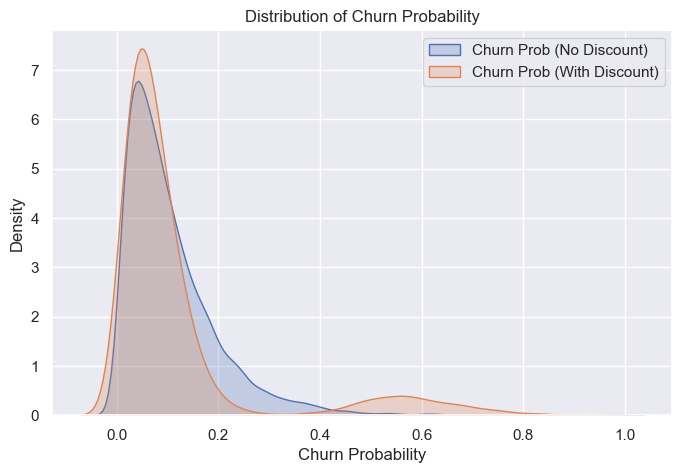

In [27]:
plt.figure(figsize=(8,5))
sns.kdeplot(customer_prob['1'], label='Churn Prob (No Discount)', shade=True)
sns.kdeplot(customer_prob['1_dis'], label='Churn Prob (With Discount)', shade=True)
plt.title("Distribution of Churn Probability")
plt.xlabel("Churn Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

**With the discount, the churn probability for some customers decreases slightly** (the distribution shifts left), but the effect is not uniform. This indicates that the discount **effectively retains high-risk customers**, while low-risk customers see little to no change.

#### Expected Profit Comparison

Next, we evaluate how the discount impacts expected profit for each customer. This plot compares expected profit without the discount versus with the discount.

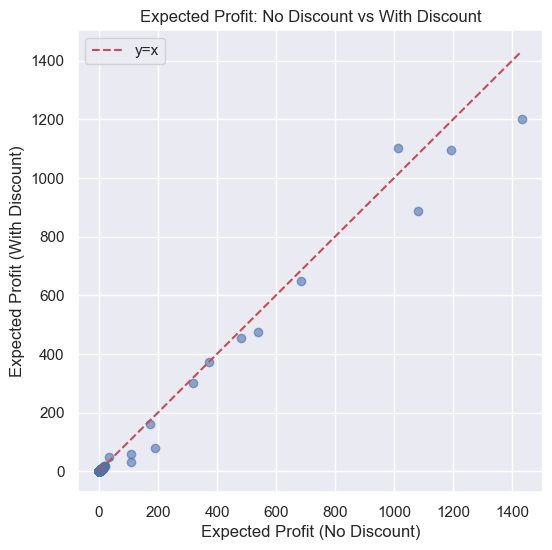

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(customer_prob['expected_no_dis'], customer_prob['expected_dis'], alpha=0.6)
plt.plot([customer_prob['expected_no_dis'].min(), customer_prob['expected_no_dis'].max()],
         [customer_prob['expected_no_dis'].min(), customer_prob['expected_no_dis'].max()],
         'r--', label="y=x")
plt.title("Expected Profit: No Discount vs With Discount")
plt.xlabel("Expected Profit (No Discount)")
plt.ylabel("Expected Profit (With Discount)")
plt.legend()
plt.show()

Most customers cluster **along the diagonal**, meaning discounts don’t change profitability.
But importantly, a subset of **churn-prone customers move above the line**, meaning they generate **higher profit under the discount scenario**. This validates the selective benefit of offering discounts only to the right customers.

#### Customer Segmentation

Finally, to identify which customers are best suited for targeted discounts, we plot churn probability against the profit difference between discounted and non-discounted scenarios.

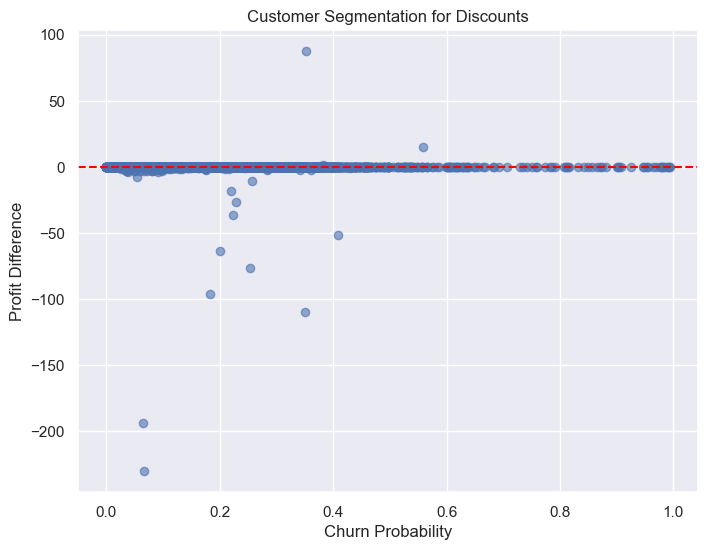

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(customer_prob['1'], customer_prob['diff_discount'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Customer Segmentation for Discounts")
plt.xlabel("Churn Probability")
plt.ylabel("Profit Difference")
plt.show()

- Customers in the **top-right quadrant** (high churn probability + positive ΔProfit) are **ideal discount targets**.
- Customers **below the red line** should not receive discounts, as it reduces profit.

This segmentation provides a clear retention strategy: **focus on discounting where it drives net gain**.

### Final Recommendation

- Broad, across-the-board discounts are ineffective — they reduce overall profit while barely improving churn.

- With SmartChurn, discounts become a **strategic retention lever**:

  - Apply 20% discounts only to customers **with high churn probability and positive ΔProfit**.
  - Avoid discounts for **low-risk customers** or those unlikely to yield profit gains.

By targeting discounts in this way, the company can **maximize retention impact** while **protecting profitability**, ensuring resources are spent where they deliver the greatest business value.